In [1]:
# downloads C3D weights from https://github.com/aslucki/C3D_Sport1M_keras
!mkdir weights
!gdown --id 1rlZ-xTkTMjgWKiQFUedRnHlDgQwx6yTm -O weights/weights.h5

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rlZ-xTkTMjgWKiQFUedRnHlDgQwx6yTm
To: /content/weights/weights.h5
100% 320M/320M [00:08<00:00, 38.7MB/s]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

zip_f="GMDCSA.zip"

# zip_f="CAUCAFall.zip"
zip_f

'GMDCSA.zip'

In [4]:
import os
zip_f_noExt = os.path.splitext(os.path.basename(zip_f))[0]

print(zip_f_noExt)

GMDCSA


In [5]:
video_baseZipPath="/content/drive/MyDrive/Colab Notebooks/EA/"+zip_f
video_baseZipPath

'/content/drive/MyDrive/Colab Notebooks/EA/GMDCSA.zip'

In [6]:
frame_n=16
frame_n


16

In [7]:
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile(video_baseZipPath, 'r') as zObject:

	# Extracting all the members of the zip
	# into a specific location.
	zObject.extractall(
		path="./")

In [14]:
# C3D definition
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
# from keras.layers.convolutional import Conv3D, MaxPooling3D, ZeroPadding3D

def create_C3D_model(summary = False):


    model = Sequential()
    input_shape = (frame_n, 112, 112, 3)

    model.add(Conv3D(64, (3, 3, 3), activation='relu',
                     padding='same', name='conv1',
                     input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2),
                           padding='valid', name='pool1'))
    # 2nd layer group
    model.add(Conv3D(128, (3, 3, 3), activation='relu',
                     padding='same', name='conv2'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool2'))
    # 3rd layer group
    model.add(Conv3D(256, (3, 3, 3), activation='relu',
                     padding='same', name='conv3a'))
    model.add(Conv3D(256, (3, 3, 3), activation='relu',
                     padding='same', name='conv3b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool3'))
    # 4th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv4a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv4b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool4'))
    # 5th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv5a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv5b'))
    model.add(ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool5'))
    model.add(Flatten())
    # FC layers group
    model.add(Dense(4096, activation='relu', name='fc6'))
    model.add(Dropout(.5))
    model.add(Dense(4096, activation='relu', name='fc7'))
    model.add(Dropout(.5))
    model.add(Dense(487, activation='softmax', name='fc8'))

    if summary:
      print(model.summary())

    return model

In [15]:
 # Number of cameras
num_cameras = 8  # Adjust this based on the actual number of cameras
# Generate the camera folder names dynamically
cams = [f"cam{i+1}" for i in range(num_cameras)]
cams


['cam1', 'cam2', 'cam3', 'cam4', 'cam5', 'cam6', 'cam7', 'cam8']

In [17]:
# Utility functions for the experiments (chunk count, video preprocessing, feature computation, )
from keras.models import model_from_json, Model
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

def getFeatureExtractor(weigthsPath, layer, verbose = False):


    model = create_C3D_model(verbose)
    model.load_weights(weigthsPath)
    model.compile(loss='mean_squared_error', optimizer='sgd')

    return Model(inputs=model.input,outputs=model.get_layer(layer).output)

def count_chunks(videoBasePath):


    folders = ['Fall', 'ADL']
    # # cams = ['cam1']
    #   # Number of cameras
    # num_cameras = 2  # Adjust this based on the actual number of cameras
    # # Generate the camera folder names dynamically
    # cams = [f"cam{i+1}" for i in range(num_cameras)]

    cnt = 0

    # TC=0

    for folder in folders:
        print("cams",cams)
        for camName in cams:
            path = os.path.join(videoBasePath, folder, camName)

            # if TC>=10:
            #   break
            # TC=TC+1

            try:
              # Attempt to access the subfolder
              videofiles = os.listdir(path)

            # try:
            # # Attempt to access the subfolder
            # videofiles = os.listdir(path)
            except FileNotFoundError:
              # Subfolder doesn't exist, continue with the next one
              continue
            for videofile in videofiles:
                filePath = os.path.join(path, videofile)
                video = cv2.VideoCapture(filePath)
                numframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
                fps = int(video.get(cv2.CAP_PROP_FPS))
                chunks = numframes//frame_n
                cnt += chunks


    return cnt

def preprocessVideos(videoBasePath, featureBasePath, verbose=True):


    folders = ['Fall', 'ADL']
    # Number of cameras
    # num_cameras = 2  # Adjust this based on the actual number of cameras
    # # Generate the camera folder names dynamically
    # cams = [f"cam{i+1}" for i in range(num_cameras)]
    # # cams = ['cam1']
    total_chunks = count_chunks(videoBasePath)
    npSamples = np.memmap(os.path.join(featureBasePath, 'samples.mmap'), dtype=np.float32, mode='w+', shape=(total_chunks, 16, 112, 112, 3))
    npLabels = np.memmap(os.path.join(featureBasePath, 'labels.mmap'), dtype=np.int8, mode='w+', shape=(total_chunks))
    cnt = 0

    # TC=0

    for folder in folders:
        for camName in cams:
            path = os.path.join(videoBasePath, folder, camName)
            # if TC>=10:
            #   break
            # TC=TC+1


            try:
              videofiles = os.listdir(path)

            except FileNotFoundError:
              # Subfolder doesn't exist, continue with the next one
              continue
            for videofile in videofiles:
                filePath = os.path.join(path, videofile)
                video = cv2.VideoCapture(filePath)
                numframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
                fps = int(video.get(cv2.CAP_PROP_FPS))
                chunks = numframes//frame_n
                if verbose:
                    print(filePath)
                    print("*** [Video Info] Number of frames: {} - fps: {} - chunks: {}".format(numframes, fps, chunks))
                vid = []
                videoFrames = []
                while True:
                    ret, img = video.read()
                    if not ret:
                        break
                    videoFrames.append(cv2.resize(img, (112, 112)))
                vid = np.array(videoFrames, dtype=np.float32)
                filename = os.path.splitext(videofile)[0]
                chunk_cnt = 0
                for i in range(chunks):
                    X = vid[i*frame_n:i*frame_n+frame_n]
                    chunk_cnt += 1
                    npSamples[cnt] = np.array(X, dtype=np.float32)
                    if folder == 'Fall':
                        npLabels[cnt] = np.int8(1)
                    else:
                        npLabels[cnt] = np.int8(0)
                    cnt += 1

    if verbose:
        print("** Labels **")
        print(npLabels.shape)
        print('\n****\n')
        print("** Samples **")
        print(npSamples.shape)
        print('\n****\n')

    del npSamples
    del npLabels

def extractFeatures(weigthsPath, videoBasePath, featureBasePath='', verbose=True):



    featureExtractor = getFeatureExtractor(weigthsPath, 'fc6', verbose)

    folders = ['Fall', 'ADL']
    # # cams = ['cam1']
    #   # Number of cameras
    # num_cameras = 2  # Adjust this based on the actual number of cameras
    # # Generate the camera folder names dynamically
    # cams = [f"cam{i+1}" for i in range(num_cameras)]
    labels = []
    features = []

    # TC=0
    AllVdoFrames=0

    for folder in folders:
        for camName in cams:
            path = os.path.join(videoBasePath, folder, camName)
            featurepath = os.path.join(featureBasePath, folder, camName)
            # if TC>=10:
            #   break
            # TC=TC+1

            try:
              videofiles = os.listdir(path)

            except FileNotFoundError:
              # Subfolder doesn't exist, continue with the next one
              continue
            for videofile in videofiles:
                filePath = os.path.join(path, videofile)
                video = cv2.VideoCapture(filePath)
                numframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
                AllVdoFrames=AllVdoFrames+numframes
                fps = int(video.get(cv2.CAP_PROP_FPS))
                chunks = numframes//frame_n
                if verbose:
                    print(filePath)
                    print("*** [Video Info] Number of frames: {} - fps: {} - chunks: {}".format(numframes, fps, chunks))
                vid = []
                videoFrames = []
                while True:
                    ret, img = video.read()
                    if not ret:
                        break
                    videoFrames.append(cv2.resize(img, (112, 112)))
                vid = np.array(videoFrames, dtype=np.float32)

                filename = os.path.splitext(videofile)[0]
                if featureBasePath:
                    featureFilePath = os.path.join(featurepath, filename + '.csv')
                    with open(featureFilePath, 'ab') as f:
                        for i in range(chunks):
                            X = vid[i*frame_n:i*frame_n+frame_n]
                            out = featureExtractor.predict(np.array([X]))
                            np.savetxt(f, out)
                            out = out.reshape(4096)
                            features.append(out)
                            if folder == 'Fall':
                                labels.append(1)
                            else:
                                labels.append(0)

                    if verbose:
                        print('*** Saved file: ' + featureFilePath)
                        print('\n')
                else:
                    for i in range(chunks):
                        X = vid[i*frame_n:i*frame_n+frame_n]
                        out = featureExtractor.predict(np.array([X]))
                        out = out.reshape(4096)
                        features.append(out)
                        if folder == 'Fall':
                            labels.append(1)
                        else:
                            labels.append(0)

    y = np.array(labels)
    X = np.array(features)

    if verbose:
        print("** Labels **")
        # print(y)
        print(y.shape)
        print('\n****\n')
        print("** Features **")
        # print(X)
        print(X.shape)
        print('\n****\n')
        print("AllVdoFrames:",AllVdoFrames,"AvgNoChunks:",AllVdoFrames//16)

    return X, y

def get_labels_and_features_from_files(basePath, verbose=True):

    folders = ['Fall', 'ADL']
    # # cams = ['cam1']
    #   # Number of cameras
    # num_cameras = 2  # Adjust this based on the actual number of cameras
    # # Generate the camera folder names dynamically
    # cams = [f"cam{i+1}" for i in range(num_cameras)]
    labels = []
    features = []

    # TC=0

    for folder in folders:
        for camName in cams:
            path = os.path.join(basePath, folder, camName)
            # if TC>=10:
            #   break
            # TC=TC+1
            try:
              textfiles = os.listdir(path)

            except FileNotFoundError:
              # Subfolder doesn't exist, continue with the next one
              continue
            for textfile in textfiles:
                filePath = os.path.join(path, textfile)
                chunks = np.loadtxt(filePath)
                for chunk in chunks:
                  features.append(chunk)
                  if folder == 'Fall':
                    labels.append(1)
                  else:
                    labels.append(0)

    y = np.array(labels)
    X = np.array(features)

    if verbose:
        print("** Labels **")
        print("*************cams",cams)
        # print(y)
        print(y.shape)
        print('\n****\n')
        print("** Features **")
        # print(X)
        print(X.shape)
        print('\n****\n')
        print("*************cams",cams)

    return X, y


In [ ]:
# cams

In [18]:
# folders to store samples and features during the experiments
featureBasePath1=zip_f_noExt+"_Dataset"
os.makedirs(featureBasePath1, exist_ok=True)
os.makedirs(os.path.join(featureBasePath1, "Fall"),exist_ok=True)
os.makedirs(os.path.join(featureBasePath1, "ADL"),exist_ok=True)
os.makedirs(os.path.join(featureBasePath1, "results"),exist_ok=True)

for cam in cams:
    cam_pathF = os.path.join(featureBasePath1, f"Fall/{cam}")
    os.makedirs(cam_pathF, exist_ok=True)
    cam_pathA = os.path.join(featureBasePath1, f"ADL/{cam}")
    os.makedirs(cam_pathA, exist_ok=True)


featureBasePath1

'GMDCSA_Dataset'

In [22]:
extractFeatures('weights/weights.h5', zip_f_noExt, featureBasePath1, True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv3D)              (None, 16, 112, 112, 64   5248      
                             )                                   
                                                                 
 pool1 (MaxPooling3D)        (None, 16, 56, 56, 64)    0         
                                                                 
 conv2 (Conv3D)              (None, 16, 56, 56, 128)   221312    
                                                                 
 pool2 (MaxPooling3D)        (None, 8, 28, 28, 128)    0         
                                                                 
 conv3a (Conv3D)             (None, 8, 28, 28, 256)    884992    
                                                                 
 conv3b (Conv3D)             (None, 8, 28, 28, 256)    1769728   
                                                        

(array([[7.976535  , 0.        , 4.944584  , ..., 0.        , 1.4547671 ,
         0.        ],
        [5.648047  , 0.        , 4.737968  , ..., 0.        , 2.6781883 ,
         0.        ],
        [6.838247  , 0.        , 2.8418245 , ..., 0.        , 2.3027453 ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.7659997 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.21724743, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1

** Labels **
*************cams ['cam1', 'cam2', 'cam3', 'cam4', 'cam5', 'cam6', 'cam7', 'cam8']
(360,)

****

** Features **
(360, 4096)

****

*************cams ['cam1', 'cam2', 'cam3', 'cam4', 'cam5', 'cam6', 'cam7', 'cam8']
ytestBinCount [61 48]
yBinCount [201 159]
confusion matrix split 1
[[61  0]
 [ 0 48]]
              precision    recall  f1-score   support

         ADL       1.00      0.98      0.99        61
        Fall       0.98      1.00      0.99        48

    accuracy                           0.99       109
   macro avg       0.99      0.99      0.99       109
weighted avg       0.99      0.99      0.99       109

Accuracy: 1.0


ytestBinCount [61 48]
yBinCount [201 159]
confusion matrix split 2
[[61  0]
 [ 1 47]]
              precision    recall  f1-score   support

         ADL       1.00      1.00      1.00        61
        Fall       1.00      1.00      1.00        48

    accuracy                           1.00       109
   macro avg       1.00      1.00      1

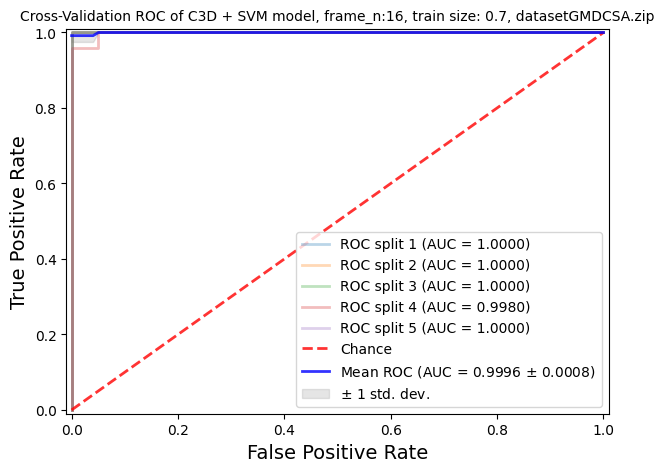

frame_n: 16 train size: 0.7
dataset GMDCSA.zip
Accuracies
[1.0, 0.9908256880733946, 1.0, 0.9724770642201835, 1.0]
Sensitivities
[1.         0.97916667 1.         0.9375     1.        ]
specificities
[1. 1. 1. 1. 1.]
F1-scores
[1.         0.98947368 1.         0.96774194 1.        ]
Avg accuracy: 0.9926605504587156 +/- 0.010698994302468418
Avg sensitivity: 0.9833333333333332 +/- 0.02429563289518875
Avg specificity: 1.0 +/- 0.0
Avg f1-score: 0.9914431239388793 +/- 0.01253224170529419


In [23]:
# import pandas as pd
import numpy as np
import sklearn
from sklearn import svm
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
import matplotlib.pylab as plt

t_size=0.7

X, y = get_labels_and_features_from_files(featureBasePath1, True)
#

# Cross Validation
clf = svm.SVC(kernel='linear', C = 1, probability=True)

# nsplits = 5
nsplits = 5
#cv = StratifiedKFold(n_splits=nsplits, shuffle=True)
cv = StratifiedShuffleSplit(n_splits=nsplits, train_size=t_size, random_state=33)


tprs = []
aucs = []
scores = []
sens = np.zeros(shape=(nsplits))
specs = np.zeros(shape=(nsplits))
f1Scores = np.zeros(shape=(nsplits))
mean_fpr = np.linspace(0, 1, 100)
plt.figure(num=1, figsize=(7,5))
i = 1
for train, test in cv.split(X, y):
    # train = sklearn.utils.shuffle(train)
    clf.fit(X[train], y[train])
    pred_acc = clf.predict(X[test])
    split_acc = accuracy_score(y[test], pred_acc)
    scores.append(split_acc)
    prediction = clf.predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], prediction[:, 1], pos_label=1)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC split %d (AUC = %0.4f)' % (i, roc_auc))
    print("ytestBinCount",np.bincount(y[test]))
    print("yBinCount",np.bincount(y))
    print('confusion matrix split ' + str(i))
    print(confusion_matrix(y[test], pred_acc))

    # y_pred = prediction.argmax(axis=-1)
    report = classification_report(y[test], pred_acc, target_names=['ADL', 'Fall'], output_dict=True)
    sens[i - 1] = report['Fall']['recall']
    specs[i - 1] = report['ADL']['recall']
    f1Scores[i - 1] = report['Fall']['f1-score']
    print(classification_report(y[test], prediction.argmax(axis=-1), target_names=['ADL', 'Fall']))
    print('Accuracy: ' + str(split_acc))
    print('\n')
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)

title=f'Cross-Validation ROC of C3D + SVM model, frame_n:{frame_n}, train size: {t_size}, dataset{zip_f}'
# title = f'Cross-Validation ROC of C3D + SVM model (Variable Value: {variable_value})'
plt.title(title,fontsize=10)
plt.legend(loc="lower right", prop={'size': 10})

plt.savefig('C3D_SVM' + '.pdf')
plt.show()
print("frame_n:",frame_n,"train size:",t_size)
print("dataset",zip_f)
print('Accuracies')
print(scores)
print('Sensitivities')
print(sens)
print('specificities')
print(specs)
print('F1-scores')
print(f1Scores)
print("Avg accuracy: {0} +/- {1}".format(np.mean(scores, axis=0), np.std(scores, axis=0)))
print("Avg sensitivity: {0} +/- {1}".format(np.mean(sens), np.std(sens)))
print("Avg specificity: {0} +/- {1}".format(np.mean(specs), np.std(specs)))
print("Avg f1-score: {0} +/- {1}".format(np.mean(f1Scores), np.std(f1Scores)))
# print("AccAll",split_acc)